In [58]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [59]:
# Define dataset paths
data_dir = "archive"
train_dir = os.path.join(data_dir, "training")
test_dir = os.path.join(data_dir, "testing")

In [60]:
# Image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [61]:
#  Advanced Data Augmentation (Prevents Overfitting)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,  
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3, 
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  
    fill_mode='nearest',
    validation_split=0.2  # 20% for validation
)

In [62]:
# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [63]:
# Load test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 1311 images belonging to 4 classes.


In [64]:
# Define base models
def build_model(base_model):
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(4, activation='softmax')(x)  # 4 classes
    model = Model(inputs, outputs)
    return model

In [ ]:
# Instantiate models
models = {
    "Xception": build_model(Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))),
    "NASNetLarge": build_model(NASNetLarge(weights='imagenet', include_top=False, input_shape=(224, 224, 3))),
    "NASNetMobile": build_model(NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))),
    "InceptionV3": build_model(InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))),
    "VGG16": build_model(VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))),
    "ResNet50": build_model(ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))),
}

In [66]:
# Compile models
for name, model in models.items():
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(f"{name} model compiled successfully.")

VGG16 model compiled successfully.
InceptionV3 model compiled successfully.
ResNet50 model compiled successfully.
Xception model compiled successfully.
NASNetMobile model compiled successfully.
NASNetLarge model compiled successfully.


In [ ]:
# Train models
history = {}
for name, model in models.items():
    print(f"Training {name} model...")
    checkpoint = ModelCheckpoint(f"best_{name}.keras", save_best_only=True, monitor='val_accuracy', mode='max')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history[name] = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,
        callbacks=[checkpoint, early_stopping]
    )

print("Training complete.")


Training VGG16 model...
Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1151s 8s/step - accuracy: 0.8058 - loss: 0.5204 - val_accuracy: 0.6906 - val_loss: 0.7737
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1137s 8s/step - accuracy: 0.8490 - loss: 0.4262 - val_accuracy: 0.7441 - val_loss: 0.6780
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1101s 8s/step - accuracy: 0.8611 - loss: 0.4059 - val_accuracy: 0.7353 - val_loss: 0.6569
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1073s 8s/step - accuracy: 0.8564 - loss: 0.3917 - val_accuracy: 0.7441 - val_loss: 0.6579
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1082s 8s/step - accuracy: 0.8709 - loss: 0.3669 - val_accuracy: 0.7590 - val_loss: 0.6269
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1103s 8s/step - accuracy: 0.8692 - loss: 0.3644 - val_accuracy: 0.7520 - val_loss: 0.6890
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1106s 8s/step - accuracy: 0.8856 - loss: 0.3342 - val_accuracy: 0.7774 - val_loss: 0.5991
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1094s 8s/step - accuracy: 

In [67]:
# Evaluate models on test data
evaluation_results = {}
for name in models.keys():
    print(f"Evaluating {name} model...")
    model = load_model(f"best_{name}.keras")
    loss, accuracy = model.evaluate(test_generator)
    evaluation_results[name] = {'loss': loss, 'accuracy': accuracy}
    print(f"{name} - Test Accuracy: {accuracy:.4f}, Test Loss: {loss:.4f}")

print("Evaluation complete.")


Evaluating VGG16 model...


C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 460s 11s/step - accuracy: 0.7818 - loss: 0.5910
VGG16 - Test Accuracy: 0.8566, Test Loss: 0.4282
Evaluating InceptionV3 model...
41/41 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.8194 - loss: 0.4113
InceptionV3 - Test Accuracy: 0.8680, Test Loss: 0.3395
Evaluating ResNet50 model...
41/41 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.5298 - loss: 1.1991
ResNet50 - Test Accuracy: 0.6796, Test Loss: 0.8728
Evaluating Xception model...
41/41 ━━━━━━━━━━━━━━━━━━━━ 168s 4s/step - accuracy: 0.9463 - loss: 0.2184
Xception - Test Accuracy: 0.9580, Test Loss: 0.1819
Evaluating NASNetMobile model...
41/41 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.7956 - loss: 0.5543
NASNetMobile - Test Accuracy: 0.8650, Test Loss: 0.4009
Evaluating NASNetLarge model...
41/41 ━━━━━━━━━━━━━━━━━━━━ 454s 10s/step - accuracy: 0.8484 - loss: 0.4184
NASNetLarge - Test Accuracy: 0.8825, Test Loss: 0.3530
Evaluation complete.


Evaluating VGG16 model...
41/41 ━━━━━━━━━━━━━━━━━━━━ 419s 10s/step
VGG16 - Accuracy: 0.8566, AUC: 0.9650, Loss: 0.4282
Classification Report:
               precision    recall  f1-score   support

      glioma       0.88      0.74      0.81       300
  meningioma       0.75      0.72      0.73       306
     notumor       0.90      0.96      0.93       405
   pituitary       0.87      0.97      0.92       300

    accuracy                           0.86      1311
   macro avg       0.85      0.85      0.85      1311
weighted avg       0.86      0.86      0.85      1311



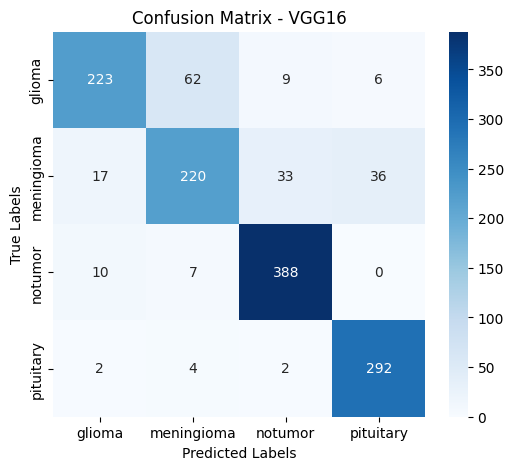

Evaluating InceptionV3 model...
41/41 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step
InceptionV3 - Accuracy: 0.8680, AUC: 0.9760, Loss: 0.3395
Classification Report:
               precision    recall  f1-score   support

      glioma       0.84      0.81      0.83       300
  meningioma       0.76      0.72      0.74       306
     notumor       0.94      0.96      0.95       405
   pituitary       0.89      0.95      0.92       300

    accuracy                           0.87      1311
   macro avg       0.86      0.86      0.86      1311
weighted avg       0.87      0.87      0.87      1311



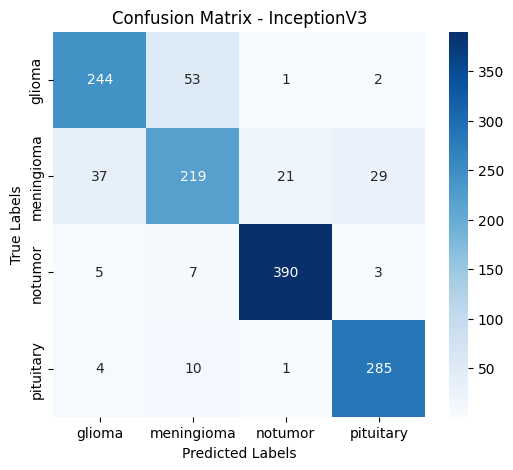

Evaluating ResNet50 model...
41/41 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step
ResNet50 - Accuracy: 0.6796, AUC: 0.8736, Loss: 0.8728
Classification Report:
               precision    recall  f1-score   support

      glioma       0.74      0.40      0.52       300
  meningioma       0.48      0.48      0.48       306
     notumor       0.76      0.92      0.83       405
   pituitary       0.72      0.84      0.77       300

    accuracy                           0.68      1311
   macro avg       0.67      0.66      0.65      1311
weighted avg       0.68      0.68      0.66      1311



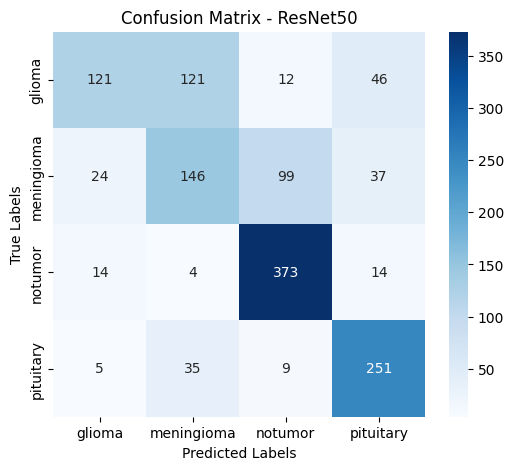

Evaluating Xception model...
41/41 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step
Xception - Accuracy: 0.9580, AUC: 0.9951, Loss: 0.1819
Classification Report:
               precision    recall  f1-score   support

      glioma       0.93      0.96      0.95       300
  meningioma       0.97      0.88      0.92       306
     notumor       0.98      0.99      0.99       405
   pituitary       0.94      0.99      0.97       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



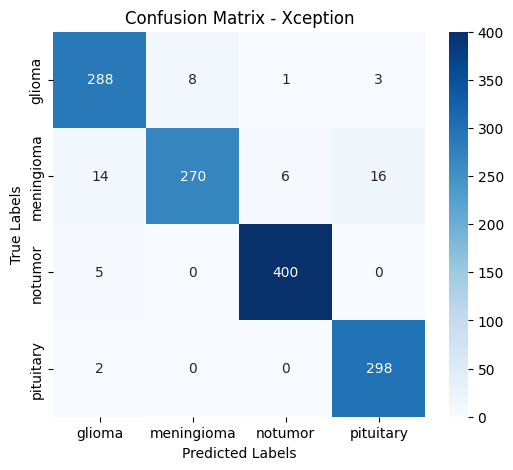

Evaluating NASNetMobile model...
41/41 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step
NASNetMobile - Accuracy: 0.8650, AUC: 0.9733, Loss: 0.4009
Classification Report:
               precision    recall  f1-score   support

      glioma       0.89      0.77      0.83       300
  meningioma       0.76      0.70      0.72       306
     notumor       0.93      0.97      0.95       405
   pituitary       0.86      0.99      0.92       300

    accuracy                           0.86      1311
   macro avg       0.86      0.86      0.85      1311
weighted avg       0.86      0.86      0.86      1311



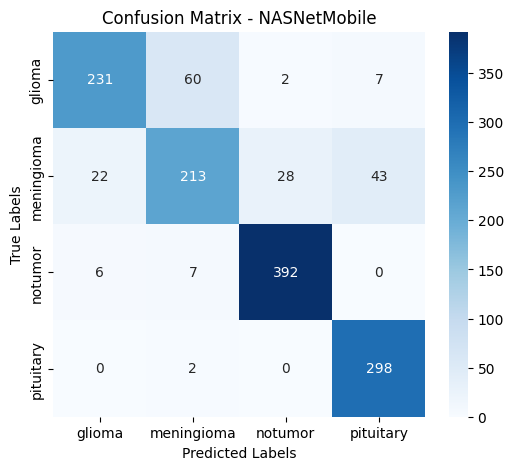

Evaluating NASNetLarge model...
41/41 ━━━━━━━━━━━━━━━━━━━━ 441s 10s/step
NASNetLarge - Accuracy: 0.8825, AUC: 0.9766, Loss: 0.3530
Classification Report:
               precision    recall  f1-score   support

      glioma       0.87      0.85      0.86       300
  meningioma       0.81      0.75      0.78       306
     notumor       0.92      0.98      0.95       405
   pituitary       0.90      0.91      0.91       300

    accuracy                           0.88      1311
   macro avg       0.88      0.87      0.88      1311
weighted avg       0.88      0.88      0.88      1311



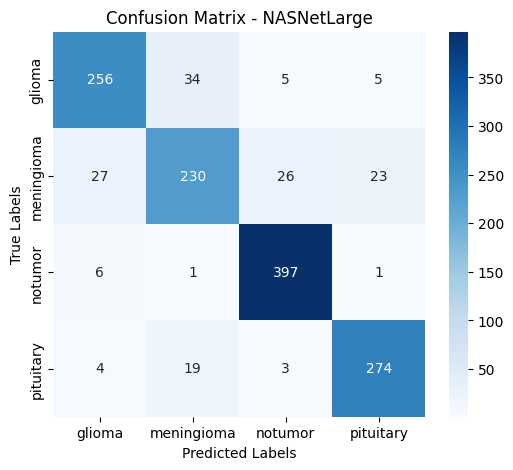

Evaluation complete.


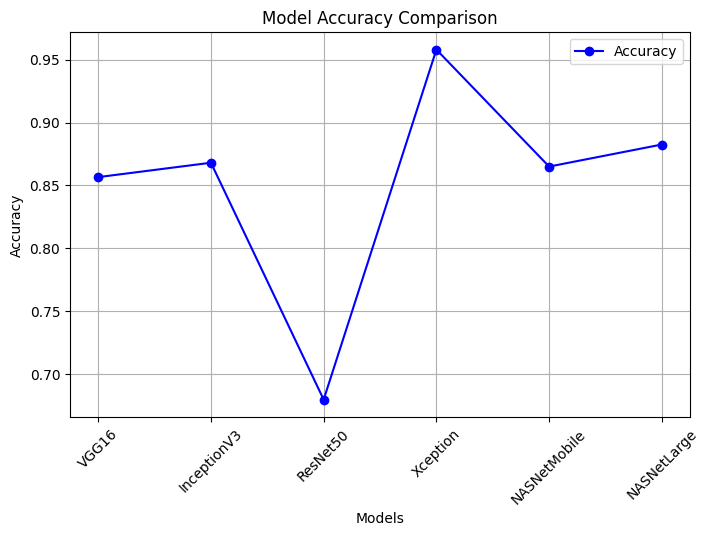

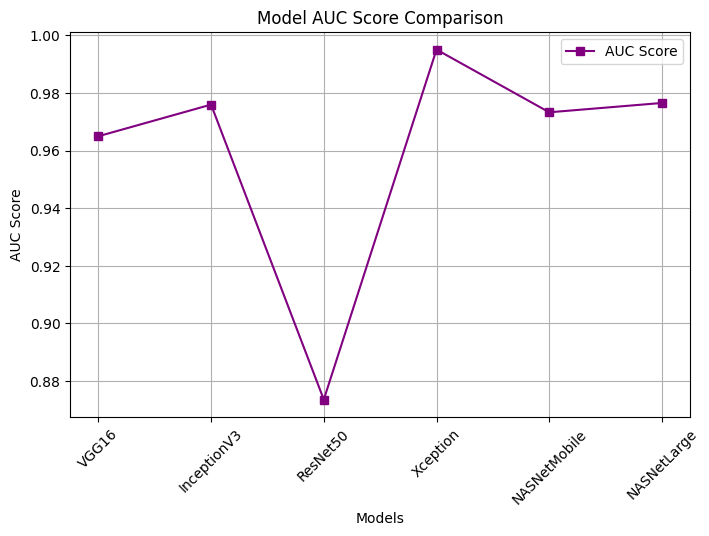

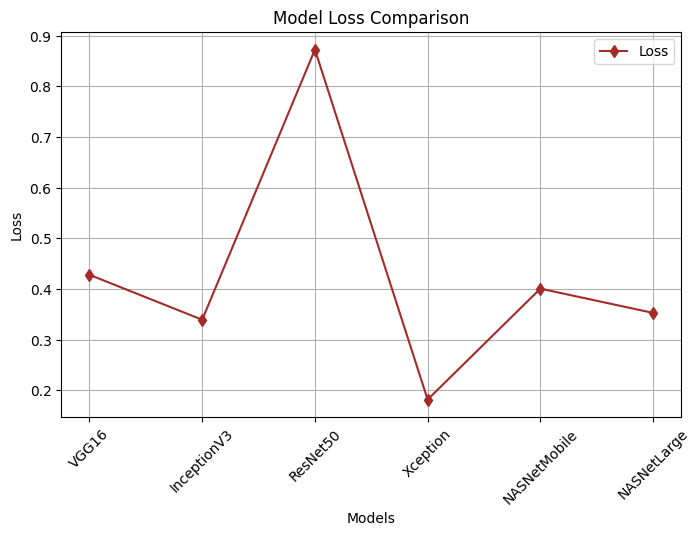

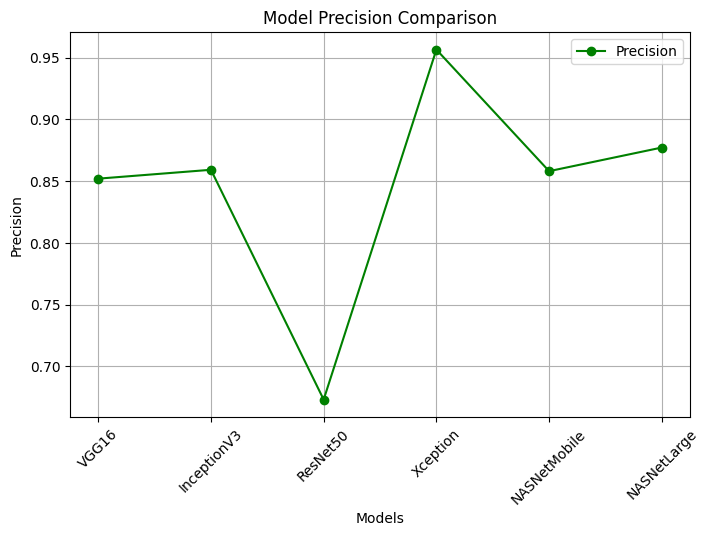

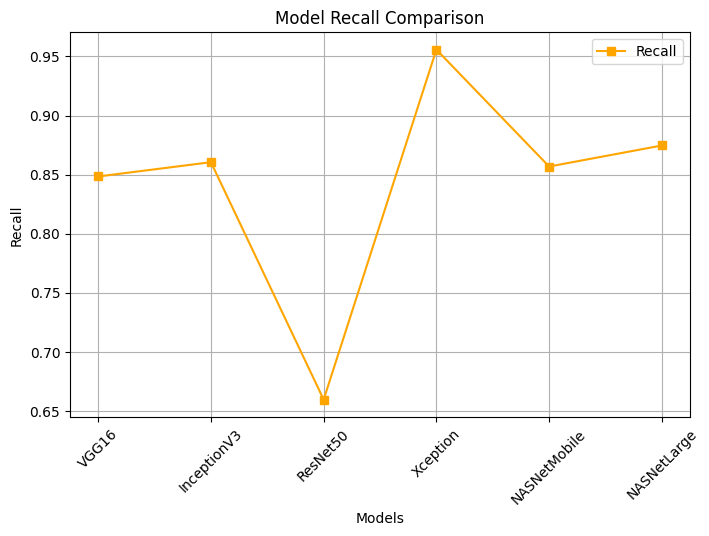

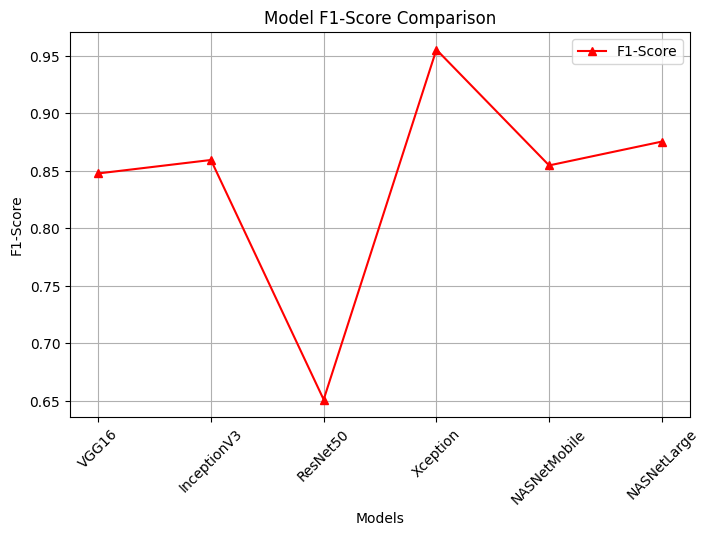

In [68]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, log_loss
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Evaluate models on test data with additional metrics
evaluation_results = {}
y_true = test_generator.classes  # True labels
class_labels = list(test_generator.class_indices.keys())

for name in models.keys():
    print(f"Evaluating {name} model...")
    model = load_model(f"best_{name}.keras")
    y_pred_probs = model.predict(test_generator)  # Predicted probabilities
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

    # Compute metrics
    report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
    conf_matrix = confusion_matrix(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred_probs, multi_class="ovr")
    loss = log_loss(y_true, y_pred_probs)  # Compute loss

    evaluation_results[name] = {
        'accuracy': report['accuracy'],
        'precision': {cls: report[cls]['precision'] for cls in class_labels},
        'recall': {cls: report[cls]['recall'] for cls in class_labels},
        'f1-score': {cls: report[cls]['f1-score'] for cls in class_labels},
        'auc': auc_score,
        'loss': loss
    }

    print(f"{name} - Accuracy: {report['accuracy']:.4f}, AUC: {auc_score:.4f}, Loss: {loss:.4f}")
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))
    
    # Confusion Matrix Visualization
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

print("Evaluation complete.")

# Extracting metrics for plotting
model_names = list(evaluation_results.keys())

accuracy_scores = [evaluation_results[name]['accuracy'] for name in model_names]
auc_scores = [evaluation_results[name]['auc'] for name in model_names]
loss_scores = [evaluation_results[name]['loss'] for name in model_names]

# Extracting class-wise precision, recall, f1-score (averaged over all classes)
precision_scores = [np.mean(list(evaluation_results[name]['precision'].values())) for name in model_names]
recall_scores = [np.mean(list(evaluation_results[name]['recall'].values())) for name in model_names]
f1_scores = [np.mean(list(evaluation_results[name]['f1-score'].values())) for name in model_names]

# Accuracy Graph
plt.figure(figsize=(8, 5))
plt.plot(model_names, accuracy_scores, marker='o', linestyle='-', color='blue', label="Accuracy")
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# AUC Graph
plt.figure(figsize=(8, 5))
plt.plot(model_names, auc_scores, marker='s', linestyle='-', color='purple', label="AUC Score")
plt.xlabel('Models')
plt.ylabel('AUC Score')
plt.title('Model AUC Score Comparison')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# Loss Graph
plt.figure(figsize=(8, 5))
plt.plot(model_names, loss_scores, marker='d', linestyle='-', color='brown', label="Loss")
plt.xlabel('Models')
plt.ylabel('Loss')
plt.title('Model Loss Comparison')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# Precision Graph
plt.figure(figsize=(8, 5))
plt.plot(model_names, precision_scores, marker='o', linestyle='-', color='green', label="Precision")
plt.xlabel('Models')
plt.ylabel('Precision')
plt.title('Model Precision Comparison')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# Recall Graph
plt.figure(figsize=(8, 5))
plt.plot(model_names, recall_scores, marker='s', linestyle='-', color='orange', label="Recall")
plt.xlabel('Models')
plt.ylabel('Recall')
plt.title('Model Recall Comparison')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# F1-Score Graph
plt.figure(figsize=(8, 5))
plt.plot(model_names, f1_scores, marker='^', linestyle='-', color='red', label="F1-Score")
plt.xlabel('Models')
plt.ylabel('F1-Score')
plt.title('Model F1-Score Comparison')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()


In [69]:
# Load Best Model for Real-World Inference
best_model_name = max(evaluation_results, key=lambda x: evaluation_results[x]['accuracy'])
print(f"Best model: {best_model_name}")
best_model = load_model(f"best_{best_model_name}.keras")

Best model: Xception


In [ ]:
def predict_image(image_path):
    from tensorflow.keras.preprocessing import image
    img = image.load_img(image_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = best_model.predict(img_array)
    class_names = list(train_generator.class_indices.keys())
    predicted_class = class_names[np.argmax(prediction)]
    return predicted_class

#Example usage:
result = predict_image("archive\Testing\meningioma\Te-me_0010.jpg")
print(f"Predicted Tumor Type: {result}")


<>:12: SyntaxWarning: invalid escape sequence '\T'
<>:12: SyntaxWarning: invalid escape sequence '\T'
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15084\590721203.py:12: SyntaxWarning: invalid escape sequence '\T'
  result = predict_image("archive\Testing\meningioma\Te-me_0010.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Tumor Type: meningioma
